# 2.5D DC Resistivity using discretize and SimPEG

In [76]:
# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    generate_survey_from_abmn_locations
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

mpl.rcParams.update({"font.size": 14})  # default font size

write_output = False  # Optional

## Define topography 
...as a numpy.ndarray. 
This comes from field data.

Texas Creek Line 1 (3 meter spacing), SW to NE.

In [3]:
topo_2d = np.array([
    [0,279.927],
    [3.01915288980899,279.839],
    [6.01871657194297,279.798],
    [9.01509641382899,279.704],
    [11.976175211019,279.76],
    [14.957392764668,279.755],
    [17.960852362733,279.75],
    [20.954058832204,279.866],
    [23.952541548375,279.964],
    [26.958478231569,279.897],
    [29.955796792385,279.946],
    [32.960307511571,279.9],
    [35.947133825114,279.923],
    [38.962001260389,279.843],
    [41.846642934072,279.635],
    [44.732364485303,278.727],
    [47.457402444251,277.535],
    [50.36333231884,276.393],
    [53.1583333550149,275.408],
    [55.948892798939,274.541],
    [58.901885343827,273.859],
    [61.84356224493,273.486],
    [64.822962080431,273.013],
    [67.764326976197,272.542],
    [70.784222407967,272.363],
    [73.781882740269,272.341],
    [76.76643562404,272.391],
    [79.752423513558,272.497]
])
# topo_2d

In [5]:
topo_2d[:,0] += 219.78
topo_2d

array([[219.78      , 279.927     ],
       [222.79915289, 279.839     ],
       [225.79871657, 279.798     ],
       [228.79509641, 279.704     ],
       [231.75617521, 279.76      ],
       [234.73739276, 279.755     ],
       [237.74085236, 279.75      ],
       [240.73405883, 279.866     ],
       [243.73254155, 279.964     ],
       [246.73847823, 279.897     ],
       [249.73579679, 279.946     ],
       [252.74030751, 279.9       ],
       [255.72713383, 279.923     ],
       [258.74200126, 279.843     ],
       [261.62664293, 279.635     ],
       [264.51236449, 278.727     ],
       [267.23740244, 277.535     ],
       [270.14333232, 276.393     ],
       [272.93833336, 275.408     ],
       [275.7288928 , 274.541     ],
       [278.68188534, 273.859     ],
       [281.62356224, 273.486     ],
       [284.60296208, 273.013     ],
       [287.54432698, 272.542     ],
       [290.56422241, 272.363     ],
       [293.56188274, 272.341     ],
       [296.54643562, 272.391     ],
 

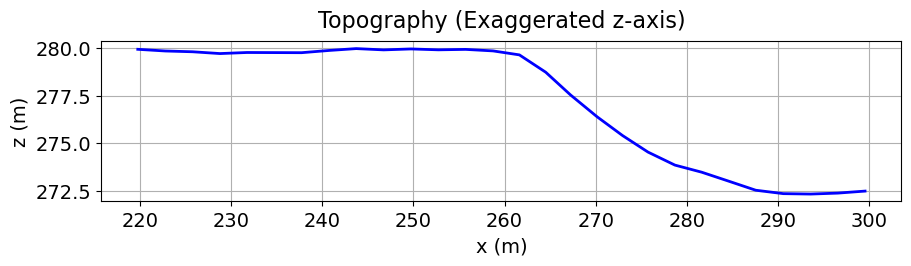

In [6]:
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:,0], topo_2d[:,1], color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

## Define the survey
Using simpeg.electromagnetics.static.utils.generate_survey_from_abmn_locations

In [57]:
column_names = ['datum', 'user', 'date', 'time', 'V/I', '%error', 'I', 'apparentRes',
                'commandFile',
                'Ax','Ay','Az',
                'Bx', 'By', 'Bz',
                'Mx', 'My', 'Mz',
                'Nx', 'Ny', 'Nz']

In [62]:
locations = pd.read_table('./fieldData/3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_corrected.stg', header=0, names=column_names, skiprows=2, delimiter=',', skipinitialspace=True)

In [63]:
locations

,datum,user,date,time,V/I,%error,I,apparentRes,commandFile,Ax,...,Az,Bx,By,Bz,Mx,My,Mz,Nx,Ny,Nz
0,1,USER,19970127,01:43:50,13.619000,0,100,768.012,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,222.80,...,0.0,219.78,0.0,0.0,225.79,0.0,0.0,228.82,0.0,0.0
1,2,USER,19970127,01:44:03,14.129000,0,100,803.478,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,225.79,...,0.0,222.80,0.0,0.0,228.82,0.0,0.0,231.80,0.0,0.0
2,3,USER,19970127,01:44:16,16.094000,0,100,890.474,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,228.82,...,0.0,225.79,0.0,0.0,231.80,0.0,0.0,234.79,0.0,0.0
3,4,USER,19970127,01:44:31,15.828000,0,50,889.115,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,231.80,...,0.0,228.82,0.0,0.0,234.79,0.0,0.0,237.77,0.0,0.0
4,5,USER,19970127,01:44:44,15.920000,0,100,904.030,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,234.79,...,0.0,231.80,0.0,0.0,237.77,0.0,0.0,241.23,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,USER,19970127,02:36:33,0.043859,9,20,244.028,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,247.23,...,0.0,237.77,0.0,0.0,291.06,0.0,0.0,300.01,0.0,0.0
211,212,USER,19970127,02:36:49,0.052734,5,50,474.672,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,228.82,...,0.0,219.78,0.0,0.0,282.12,0.0,0.0,291.06,0.0,0.0
212,213,USER,19970127,02:37:04,0.047357,2,100,428.210,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,231.80,...,0.0,222.80,0.0,0.0,285.10,0.0,0.0,294.06,0.0,0.0
213,214,USER,19970127,02:37:18,0.037273,2,100,335.471,3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_cor...,234.79,...,0.0,225.79,0.0,0.0,288.03,0.0,0.0,297.03,0.0,0.0


In [64]:
locations.columns

Index(['datum', 'user', 'date', 'time', 'V/I', '%error', 'I', 'apparentRes',
       'commandFile', 'Ax', 'Ay', 'Az', 'Bx', 'By', 'Bz', 'Mx', 'My', 'Mz',
       'Nx', 'Ny', 'Nz'],
      dtype='object')

In [74]:
locations_a = locations.loc[:,'Ax']
locations_b = locations.loc[:,'Bx']
locations_m = locations.loc[:,'Mx']
locations_n = locations.loc[:,'Nx']

In [87]:
location_a = np.array(locations_a)
location_b = np.array(locations_b)
location_m = np.array(locations_m)
location_n = np.array(locations_n)

loc_a = np.c_(location_a, topo_2d[:,1])
loc_b = np.c_(location_b, topo_2d[:,1])
loc_m = np.c_(location_m, topo_2d[:,1])
loc_n = np.c_(location_n, topo_2d[:,1])

TypeError: 'CClass' object is not callable

In [84]:
survey = generate_survey_from_abmn_locations(locations_a=location_a, locations_b= location_b, locations_m=location_m, locations_n=location_n, data_type='apparent_resistivity')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed